# Physics 390 - Climate Modelling

The first stage of modelling is to import relevant modules into the notebook. After this, data can be loaded in for each data file provided.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from datetime import datetime 
from datetime import timedelta 

In [ ]:
# Load satellite data

# Data directories
SATELLITE_DATA_DIR = "Satellite Data/"

# Full satellite data file paths
cloud_fraction_phase_file = SATELLITE_DATA_DIR + '3D_CloudFraction_Phase330m_200606-201803_avg_CFMIP2_sat_3.1.2.nc'
cloud_fraction_file = SATELLITE_DATA_DIR + '3D_CloudFraction330m_200606-201803_avg_CFMIP2_sat_3.1.2.nc'
ECMWF_ta_plevels_file = SATELLITE_DATA_DIR + 'ECMWF_ta_plevels_2001_2018.nc'
map_low_high_mid_high_file = SATELLITE_DATA_DIR + 'MapLowMidHigh330m_200606-201803_avg_CFMIP2_sat_3.1.2.nc'

# Load satellite data into variables with read access
cloud_fraction_phase_data = Dataset(cloud_fraction_phase_file, 'r')
cloud_fraction_data = Dataset(cloud_fraction_file, 'r')
ECMWF_ta_plevels_data = Dataset(ECMWF_ta_plevels_file, 'r')
map_low_high_mid_high_data = Dataset(map_low_high_mid_high_file, 'r')

In [2]:
# Load model data

# Data directories
MODEL_DATA_DIR = "Model Data/"

# Full model data file paths
cl_data_file = MODEL_DATA_DIR + 'clcalipso_CFmon_CESM2_amip_r2i1p1f1_gn_195001-201412.nc'
clt_data_file = MODEL_DATA_DIR + 'cltcalipso_CFmon_CESM2_amip_r2i1p1f1_gn_195001-201412.nc'
cl_ice_data_file = MODEL_DATA_DIR + 'clcalipsoice_CFmon_CESM2_amip_r2i1p1f1_gn_195001-201412.nc'
cl_liq_data_file = MODEL_DATA_DIR + 'clcalipsoliq_CFmon_CESM2_amip_r2i1p1f1_gn_195001-201412.nc'

# Load model data into variables with readable access
cl_data = Dataset(cl_data_file, 'r')
clt_data = Dataset(clt_data_file, 'r')
cl_ice_data = Dataset(cl_ice_data_file, 'r')
cl_liq_data = Dataset(cl_liq_data_file, 'r')

In [3]:
# Declare some helper methods for easy viewing of data

# Display the names of all data points in the dataset and the number of data points in that set
def print_dataset_overview(dataset):
    print("Variables and Number of Data Points:")
    for key in dataset.variables.keys():
        print("\t", key, ": ", len(dataset.variables[key][:]), " data points")
    print("\n")

# Display the data for the variable name provided
def print_data_points(dataset, variable_name):
    print(variable_name, ":")
    print(dataset.variables[variable_name][:])
    print("\n")

def print_variables(dataset):
    for key in dataset.variables.keys():
        print(key, ": ", dataset.variables[key])
        print("\n")

In [4]:
## Declare some global variables
FIG_WIDTH = 10
FIG_HEIGHT = 5

### Clt Data Structure
From the helper methods above, and after analysing output data for the clt dataset, it appears that the clt data is organised in the following structure:

$cltcalipso[time][lat][lon]=$ fraction cloud cover at given $time$ at the coordinate $(lat, lon)$

In [ ]:
print_dataset_overview(clt_data)
print_data_points(clt_data, "lon")
print_data_points(clt_data, "lat")
print_data_points(clt_data, "cltcalipso")

### First Test Plot: Initial Percentage Cloud Cover
The following plot is playing around with clt data. This is an attempt at plotting the fractional cloud cover at all a range of latitude coordinates, at the first time interval of the dataset.

C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  # This is added back by InteractiveShellApp.init_path()


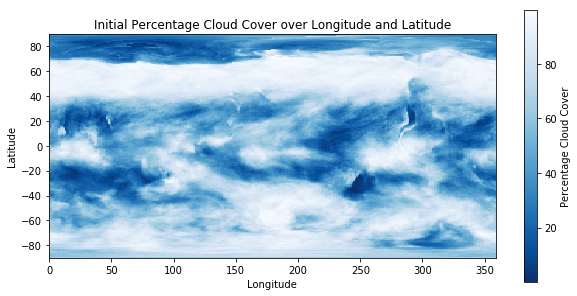

In [59]:
# Plot the percentage cloud cover over longitude and latitude at the first time interval
time_interval = 100

lon_max = max(clt_data.variables['lon'][:])
lon_min = min(clt_data.variables['lon'][:])
lat_max = max(clt_data.variables['lat'][:])
lat_min = min(clt_data.variables['lat'][:])

# Since cloud cover is collected at linearly separated long, lat coords can approximate with this plot
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
color_map = plt.imshow(clt_data.variables['cltcalipso'][time_interval], interpolation='nearest', 
                       extent=[lon_min, lon_max, lat_min, lat_max])

color_map.set_cmap("Blues_r")
plt.title("Initial Percentage Cloud Cover over Longitude and Latitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar = plt.colorbar()
cbar.set_label("Percentage Cloud Cover")

### Helper function to extract either summer or winter seasonal data

In [32]:
# Helper function to extract time data for summer and winter periods

def extract_seasonal_data_for_variable(times, data, season):
    # Units of time: "days since 0001-01-01 00:00:00"
    reference_datetime = datetime(year=1, month=1, day=1, hour=0, minute=0, second=0)

    seasonal_data = []

    # Find a subset of cloud cover values for each season
    for index in range(0, len(times)):
        # Find the month corresponding to the current time
        time_delta = timedelta(days=times[index])
        month = (reference_datetime + time_delta).month

        # Time period falls between December and February
        if (season == "summer" and (month == 12 or month == 1 or month == 2)):
            seasonal_data.append(data[index])

        # Time period falls between June and August
        elif (season == "winter" and (month == 6 or month == 7 or month == 8)):
            seasonal_data.append(data[index])

    return seasonal_data

def generate_seasonal_time_mask(times, season):
    # Units of time: "days since 0001-01-01 00:00:00"
    reference_datetime = datetime(year=1, month=1, day=1, hour=0, minute=0, second=0)

    times_mask = []

    # Find a subset of cloud cover values for each season
    for i in range(0, len(times)):
        # Find the month corresponding to the current time
        time_delta = timedelta(days=times[i])
        month = (reference_datetime + time_delta).month

        if (season == "summer"):
            times_mask.append(True if (month == 12 or month == 1 or month == 2) else False)

        if (season == "winter"):
            times_mask.append(True if (month == 6 or month == 7 or month == 8) else False)

    return np.array(times_mask)

<br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> 

# Altitude vs Latitude Cloud Fraction

## Seasonal Cloud Cover: Model Data 

Data points in the $clcalipso$ dataset are of the form $clcalipso[time][alt][lat][lon]$. To plot altitude vs latitude, the dataset must be averaged across all longitudal data points. Please note that most array manipulation operations are done on a single line to conserve program memory from not generating intermediary arrays. I realise this unfortunately reduces readability of the code.

In [60]:
# Global variables used for plotting

# Convert altitude to km
ALT_MIN = np.min(cl_data.variables["alt40"][:])/1000
ALT_MAX = np.max(cl_data.variables["alt40"][:])/1000

LAT_MIN = np.min(cl_data.variables["lat"][:])
LAT_MAX = np.max(cl_data.variables["lat"][:])

In [49]:
# First, extract all data points during the summer then average over all longitudes and all times
mask = generate_seasonal_time_mask(cl_data.variables["time"][:], "summer")
avg_summer_cloud_cover = np.mean(np.mean(cl_data.variables["clcalipso"][mask], axis = 3), axis=0)[::-1]

C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  This is separate from the ipykernel package so we can avoid doing imports until


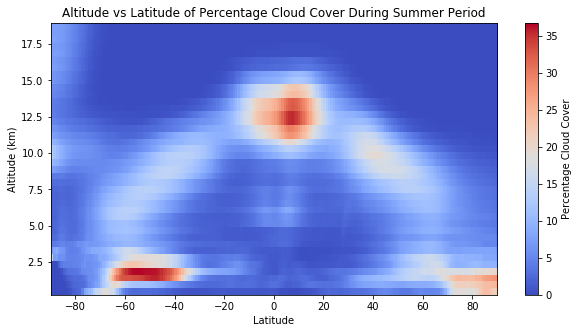

In [61]:
# Plot the altitude vs latitude for summer period
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
color_map = plt.imshow(avg_summer_cloud_cover, aspect="auto", interpolation='nearest', 
                       extent=[LAT_MIN, LAT_MAX, ALT_MIN, ALT_MAX])
color_map.set_cmap("coolwarm")
plt.title("Altitude vs Latitude of Percentage Cloud Cover During Summer Period")
plt.xlabel("Latitude")
plt.ylabel("Altitude (km)")
cbar = plt.colorbar()
cbar.set_label("Percentage Cloud Cover")

In [52]:
# First, extract all data points during the winter then average over all longitudes and all times
mask = generate_seasonal_time_mask(cl_data.variables["time"][:], "winter")
avg_winter_cloud_cover = np.mean(np.mean(cl_data.variables["clcalipso"][mask], axis = 3), axis=0)[::-1]

C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  This is separate from the ipykernel package so we can avoid doing imports until


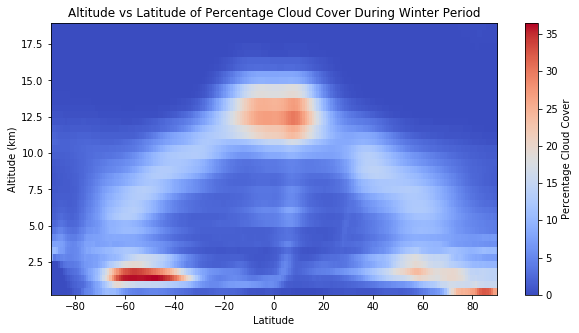

In [62]:
# Plot the altitude vs latitude for winter period
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
color_map = plt.imshow(avg_winter_cloud_cover, aspect="auto", interpolation='nearest', 
                       extent=[LAT_MIN, LAT_MAX, ALT_MIN, ALT_MAX])
color_map.set_cmap("coolwarm")
plt.title("Altitude vs Latitude of Percentage Cloud Cover During Winter Period")
plt.xlabel("Latitude")
plt.ylabel("Altitude (km)")
cbar = plt.colorbar()
cbar.set_label("Percentage Cloud Cover")

<br /> <br />
## Regional Cloud Cover: Model Data

In [ ]:
a = [  [  [[1, 2, 3], [2, 3, 4]], [[5, 6, 7], [6, 7, 8]],
      [[1, 2, 3], [2, 3, 4]], [[5, 6, 7], [6, 7, 8]]  ],
      
   [  [[1, 2, 3], [2, 3, 4]], [[5, 6, 7], [6, 7, 8]],
      [[1, 2, 3], [2, 3, 4]], [[5, 6, 7], [6, 7, 8]]  ]  ]

print(a[0][0][1])

b = np.mean(a, axis=3)
print(b[0][0][1])

<br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> 

# Top of the Atmosphere Cloud Fraction 


## Seasonal Cloud Cover: Model Data

In [64]:
# Extract all time and TOA cloud fraction data from dataset
summer_mask = generate_seasonal_time_mask(clt_data.variables["time"][:], "summer")
winter_mask = generate_seasonal_time_mask(clt_data.variables["time"][:], "winter")

# Find subset of TOA cloud cover for each season
avg_cloud_cover_summer = np.mean(clt_data.variables["cltcalipso"][summer_mask], axis=0)[::-1]
avg_cloud_cover_winter = np.mean(clt_data.variables["cltcalipso"][winter_mask], axis=0)[::-1]

C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  
C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  import sys


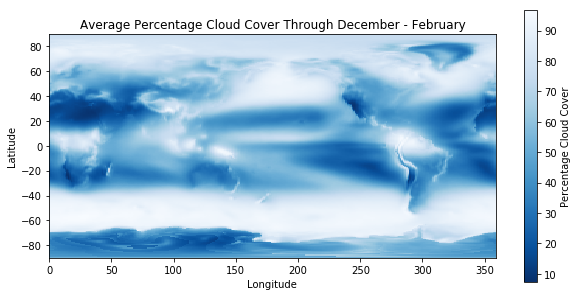

In [68]:
# Plot the average percentage of cloud cover through the winter months
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
color_map = plt.imshow(avg_cloud_cover_summer, interpolation='nearest', 
                       extent=[lon_min, lon_max, lat_min, lat_max])

color_map.set_cmap("Blues_r")
plt.title("Average Percentage Cloud Cover Through December - February")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar = plt.colorbar()
cbar.set_label("Percentage Cloud Cover")

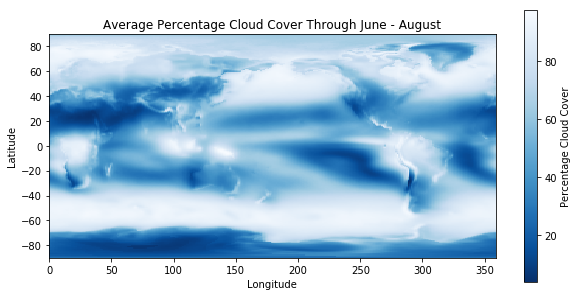

In [67]:
# Plot the average percentage of cloud cover through the summer months
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
color_map = plt.imshow(avg_cloud_cover_winter, interpolation='nearest', 
                       extent=[lon_min, lon_max, lat_min, lat_max])

color_map.set_cmap("Blues_r")
plt.title("Average Percentage Cloud Cover Through June - August")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar = plt.colorbar()
cbar.set_label("Percentage Cloud Cover")

## Seasonal Cloud Cover: Satellite Data

In [ ]:
print_variables(clt_data)

In [ ]:
print_variables(ECMWF_ta_plevels_data)